# Knowledge Graphs: Pathfinding and Graph Learning

## 1. Description

In this exercise, we will generate a routable graph and perform a Dijkstra-routing on this graph, finding the shortest possible route from a starting location to a destination!
To achieve this, we will follow the steps of the routing process as illustrated in the lecture.
Afterwards we will use different pre defined graphs to show the random walk based node embedding method. 
In addition we will define a Graph Convolutional Network and train this on a large scaled dataset. 

In order to execute the code of this practice session, you will need the following python packages. This exercise has been designed to mostly employ standard python packages, in order to make its content more comprehendable without knowing anything about exotic python modules. There are however more efficient ways of solving the presented problem with python by using pre-existing routing or graph libraries.
Please install all missing packages prior to proceeding!

In [2]:
## Imports for this exercise

# Used for visualizing our graph
from matplotlib import pyplot as plt 

# Used to calculate distances from GPS-Coordinates, see: https://en.wikipedia.org/wiki/Haversine_formula
from haversine import haversine

# Used to measure computing time
import time

# Used to calculate angles
from math import atan, degrees, pi

# Used to define Metaclasses
import abc

# Used to generate random origin and destination points for the routing
import random

# Used to define custom graph networks
import networkx as nx

# Used for general numerical calculations
import numpy as np

# This package includes the random walk and node2vec algorithm
from node2vec import Node2Vec

## 2. Generate a Routable Graph

It is known from the lecture, that all routing algorithms rely on a graph representation of the street network on which the routing shall take place. In order to derive such a graph representation, a data model of the street domain in question has to be set up first. 
The graph representation generated from the data model, has to be pre-processed, in order to generate a routable graph. These processes and all corresponding programming steps shall be presented in this section. 

### 2.1 The Map

In this subsection, a set of streets for the routing task is defined. This set of streets is then represented in a digital data model similar to the OSM data model.

Before data collection can take place, a spatial area on which the operations shall take place is to be defined. For this practise session, we choose this area to be the surroundings of the TUM "Stammgelände".

Suppose the following image generated with https://mapstyle.withgoogle.com/ :  

This image is not an original satellite image. Instead, it is a image rendered from a digital map. This representation has been chosen for this practice session for the sake of simplicity. All further steps could as well be carried out using original satellite imagery. Instead of using satellite imagery, all data can as well be generated using a GPS tracking device.

### 2.2 Defining a Data Model

In order to model the physical street network digitally, we make use of a data model similar to the one described in the lecture (OSM). In order to structure all necessary data for generating the routable graph, we introduce classes for the most important entities used to model street geometries: Nodes and Ways.

With the help of these classes, a data model can be filled with GPS data extracted from satellite imagery or GPS tracking devices. The data model is then translated to a routable graph in the subsequent sections.

#### 2.2.1 The Node Class

The most intuitive geometric entity of a digital map is the node. The node represents an arbitrary location in the map space, given by its geographic coordinates (Latitude, Longitude).
The following figure shows the already introduced street network used in this practical session. This time however, it is extended by the nodes that shall be contained in our digital map.

The following code excerpt serves to generate a node class for our data model. In it, all explanations from above are reflected.

In [3]:
# Lecture: Defined by latitude, longitude and node id. Represents arbitrary locations. Attributes specified by tags.

class Node:
    
    # This defines how a Node Object is initialized!
    def __init__(self, ID, lat, lon):
         
        # Each node has an ID to uniquely identify it    
        self.ID = ID 
        
        # The nodes position shall be given by its geo-coordinates (Latitude and Longitude)
        self.lat = lat
        self.lon = lon
        
        # A tag specifies features and properties of a node. Lets suppose tag is a dictionary with keys and values
        self.tag = {}
    
        # A little addition to the data model, in order to make this class reusable for graph nodes
        # This attribute is used to tell the graph compression algorithm to not get rid of this node.
        self.dont_compress = False
    
    # Add a dictionary of tags to this node
    def setTag(self, tag):
        self.tag = tag
    
    # Set dont_compress flag
    def secure(self):
        self.dont_compress = True

#### 2.2.2 The Way Class

The second big part of our data model is given by the concept of ways. Ways unite a set of nodes to a line (e.g. a street). Hence, they are defined by an ordered set of nodes as known from the lecture. A way can as well be attributed a tag, specifying further information about the way's physical meaning (i.e. "Is it a street? Is it the outlines of a house?").

The way class defines a prototype of the way concept in python and completes the data model for this exercise:

In [4]:
# Lecture: Defined by an ordered set of nodes. Groups nodes into lines. Attributes specified by tags.

class Way:
    # This defines how a Way Object is initialized!
    def __init__(self, ID):
        # Each way has an ID to uniquely identify it
        self.ID = ID 
        # A tag specifies features and properties of a way. Lets suppose tag is a dictionary with keys and values
        self.tag = {}
        # This is used to store all nodes associated with the way
        self.nodes = []
    
    # Add nodes to way
    def addNode(self, node):
        self.nodes.append(node)
    
    # Add multiple nodes to way
    def addNodes(self, nodes):
        for node in nodes:
            self.addNode(node)
    
    # Add a dictionary of tags to this way
    def setTag(self, tag):
        self.tag = tag

#### 2.2.3 Filling the Data Model

After the definition of the necessary data model took place, a digital map of "TUM Stammgelände" shall be generated making use of the pre-defined data model.

Prior to generating objects from our data model classes, data collection has to take place. The information needed to fill our digital map is to be generated by either visiting the real life "Stammgelände" and its surroundings and saving the GPS coordinates of all nodes previously shown on the map or by fitting satellite imagery into a GPS coordinate system and extracting the relevant GPS information.

Either way, all node positions have to be certain to proceed. Furthermore, it is necessary to be able to name all nodes belonging to a street. To relief you from the task of buying GPS trackers and walking out to map the "Stammgelände", all necessary GPS Coordinates and way assignments are given in this exercise (derived with the kind help of https://www.google.com/maps/place/TUM+Stammgel%C3%A4nde/@48.1491011,11.565128,17z). With this information at hand, our digital map is populated like this:

In [5]:
# Just a little helper class to automatically generate unique IDs 
class IDGen:
    def __init__(self):
        self.start = 0
        
    def next(self):
        self.start = self.start+1
        return self.start
    
    def reset(self):
        self.start = 0
    
idgen = IDGen()

# Fill data model with data retrieved from satellite imagery or gps trackers

# Nodes
n1 = Node(idgen.next(), 48.149633, 11.560805)
n2 = Node(idgen.next(), 48.149060, 11.562908)
n3 = Node(idgen.next(), 48.148731, 11.564002)
n4 = Node(idgen.next(), 48.148323, 11.565461)
n5 = Node(idgen.next(), 48.147607, 11.568036)
n6 = Node(idgen.next(), 48.146891, 11.570568)
n7 = Node(idgen.next(), 48.146168, 11.573250)
n8 = n6 # These nodes, although from different streets, are the same (street corner)
n9 = Node(idgen.next(), 48.147972, 11.571298)
n10 = Node(idgen.next(), 48.148974, 11.571952)
n11 = Node(idgen.next(), 48.150084, 11.572650)
n12 = Node(idgen.next(), 48.151036, 11.573283)
n13 = Node(idgen.next(), 48.151744, 11.573723)
n14 = n7
n15 = Node(idgen.next(), 48.148194, 11.574570)
n16 = Node(idgen.next(), 48.150270, 11.575965)
n17 = Node(idgen.next(), 48.151636, 11.562443)
n18 = Node(idgen.next(), 48.151142, 11.564194)
n19 = Node(idgen.next(), 48.150799, 11.565441)
n20 = Node(idgen.next(), 48.15040, 11.566803)
n21 = Node(idgen.next(), 48.149695, 11.569375)
n22 = n10 
n23 = n15 
n24 = Node(idgen.next(), 48.152732, 11.563115)
n25 = Node(idgen.next(), 48.152221, 11.564967)
n26 = Node(idgen.next(), 48.151522, 11.567501)
n27 = Node(idgen.next(), 48.150788, 11.570065)
n28 = Node(idgen.next(), 48.150449, 11.571324)
n29 = n11 
n30 = Node(idgen.next(), 48.153213, 11.565612)
n31 = Node(idgen.next(), 48.152489, 11.568145)
n32 = Node(idgen.next(), 48.151790, 11.570710)
n33 = Node(idgen.next(), 48.151416, 11.571946)
n34 = n12 
n35 = n16 
n36 = n30 
n37 = n25 
n38 = n18 
n39 = Node(idgen.next(), 48.149994, 11.563510)
n40 = n2 
n41 = Node(idgen.next(), 48.148090, 11.562243)
n42 = Node(idgen.next(), 48.146876, 11.561454)
n43 = Node(idgen.next(), 48.152479, 11.571174)
n44 = n32 
n45 = n27
n46 = n21
n47 = Node(idgen.next(), 48.148879, 11.568846)
n48 = n5
n49 = n31
n50 = n26
n51 = n20
n52 = Node(idgen.next(), 48.149258, 11.566059)
n53 = n4
n54 = Node(idgen.next(), 48.146399, 11.564200)
n55 = n42
n56 = Node(idgen.next(), 48.146465, 11.562928)
n57 = Node(idgen.next(), 48.146195, 11.563830)
n58 = n57
n59 = n54
n60 = n56
n61 = Node(idgen.next(), 48.147326, 11.563433)
n62 = Node(idgen.next(), 48.147422, 11.563208)
n63 = n3
n64 = n39
n65 = Node(idgen.next(), 48.149661, 11.564694)
n66 = n52
n67 = n65
n68 = n19
n69 = n33
n70 = n28

# Reset ID helper class to generate new IDs starting with 1
idgen.reset()

# Assemble ways from nodes

# Generate way object for each street modelled
Arcisstrasse = Way(idgen.next())
Luisenstrasse = Way(idgen.next())
BriennerStrasse = Way(idgen.next())
Koenigsplatz = Way(idgen.next())
RichardWagnerStrasse = Way(idgen.next())
Steinheilstrasse = Way(idgen.next())
Enhuberstrasse = Way(idgen.next())
Theresienstrasse = Way(idgen.next())
Hessstrasse = Way(idgen.next())
Schellingstrasse = Way(idgen.next())
Augustenstrasse = Way(idgen.next())
Gabelsbergerstrasse = Way(idgen.next())
BarerStrasse = Way(idgen.next())
Tuerkenstrasse = Way(idgen.next())
Schraudolphstrasse = Way(idgen.next())

# Add nodes to way objects (each way is an ordered list of nodes)
Arcisstrasse.addNodes([n43, n44, n45, n46, n47, n48])
Luisenstrasse.addNodes([n49, n50, n51, n52, n53, n54])
BriennerStrasse.addNodes([n55, n56, n57])
Koenigsplatz.addNodes([n58, n59])
RichardWagnerStrasse.addNodes([n60, n61, n62, n63])
Steinheilstrasse.addNodes([n64, n65, n66])
Enhuberstrasse.addNodes([n67, n68])
Theresienstrasse.addNodes([n17, n18, n19, n20, n21, n22, n23])
Hessstrasse.addNodes([n24, n25, n26, n27, n28, n29])
Schellingstrasse.addNodes([n30, n31, n32, n33, n34, n35])
Augustenstrasse.addNodes([n36, n37, n38, n39, n40, n41, n42])
Gabelsbergerstrasse.addNodes([n1, n2, n3, n4, n5, n6, n7])
BarerStrasse.addNodes([n8, n9, n10, n11, n12, n13])
Tuerkenstrasse.addNodes([n14, n15, n16])
Schraudolphstrasse.addNodes([n69, n70])

# Gather all streets in a list. This is our map
digital_map = [Arcisstrasse, Luisenstrasse, BriennerStrasse, Koenigsplatz, RichardWagnerStrasse, Steinheilstrasse, Enhuberstrasse, Theresienstrasse, Hessstrasse, Schellingstrasse, Augustenstrasse, Gabelsbergerstrasse, BarerStrasse, Tuerkenstrasse, Schraudolphstrasse]

# Add tags to the streets
street_names = ["Arcisstrasse", "Luisenstrasse", "Brienner Strasse", "Königsplatz", "Richard Wagner Strasse", "Steinheilstrasse", "Enhuberstrasse", "Theresienstrasse", "Heßstrasse", "Schellingstrasse", "Augustenstrasse", "Gabelsberger Strasse", "Barer Strasse", "Türkenstrasse", "Schraudolphstrasse"]

for i, way in enumerate(digital_map):
    way.setTag({"highway":"residential", "name":street_names[i]})

#### 2.2.4 Checking the Data Model

In the last subsection, a data model was defined. Subsequentely, a digital map was generated from real life GPS data. The following code generates an overview over the outcome of these processes. This is used to ensure ourselves that the contents of our digital map correctly model the real life street network around "Stammgelände".

In [6]:
print("DATA MODEL STATISTICS:")
print("----------------------\n")

print("o Number of ways: {}\n".format(len(digital_map)))

print("o Way description:\n")
for way in digital_map:
    print("\t - Name: {:25s} Type: {:22s} Number of Nodes: {}".format(way.tag['name'] ,way.tag["highway"], len(way.nodes)))

print("\no Number of nodes: {}".format(sum([len(way.nodes) for way in digital_map])))

print("\no Unique number of nodes: {}\n".format(len(set(sum([w.nodes for w in digital_map],[])))))

print("o Node description:\n")
all_nodes = sum([w.nodes for w in digital_map],[])

for way in digital_map:
    for node in way.nodes:
        print("\t - Node ID: {}\n\t\tBelongs to: {}".format(node.ID, way.tag['name']))
        print("\t\tCoordinates: ({}, {})".format(node.lat, node.lon))
        print("\t\tIs street corner: {}\n".format(all_nodes.count(node)>=2))

DATA MODEL STATISTICS:
----------------------

o Number of ways: 15

o Way description:

	 - Name: Arcisstrasse              Type: residential            Number of Nodes: 6
	 - Name: Luisenstrasse             Type: residential            Number of Nodes: 6
	 - Name: Brienner Strasse          Type: residential            Number of Nodes: 3
	 - Name: Königsplatz               Type: residential            Number of Nodes: 2
	 - Name: Richard Wagner Strasse    Type: residential            Number of Nodes: 4
	 - Name: Steinheilstrasse          Type: residential            Number of Nodes: 3
	 - Name: Enhuberstrasse            Type: residential            Number of Nodes: 2
	 - Name: Theresienstrasse          Type: residential            Number of Nodes: 7
	 - Name: Heßstrasse                Type: residential            Number of Nodes: 6
	 - Name: Schellingstrasse          Type: residential            Number of Nodes: 6
	 - Name: Augustenstrasse           Type: residential            Number

 Looking at the node description, it is clear that all nodes are fully specified by their GPS coordinates and all nodes are associated to a street.
Bear in mind that most of the nodes in the data model are street corners (i.e. belong to more than one street), but a few are not. This fact will be addressed when it comes to graph compression in section 2.3.5

### 2.3 Defining a Graph Class

As taught in the lecture, a routing algorithm relies on a mathematical graph to generate feasible paths through a street network. Up to this point, we only hold a digital map model - similar to the contents of the OSM database - but not a routable graph.

Fortunately, a mathematical graph can directly be generated from a digital map model. But before this transformation can take place, the basic elements of mathematical graphs have to be defined. This shall be done in the next two subsections before section 2.3.3 introduces a graph class which adds further functionalities to the graph. Finally, in section 2.3.4 a first graph is generated and visualized from the digital map.

#### 2.3.1 The Node Class

Just like the data model, a mathematical graph employs nodes as one of its core concepts. Because of the similarities between the data model representation and the graph representation of nodes, no extra "graph node" class is needed. Instead, the node class already introduced for the data model is recycled for the mathematical graph as well.

#### 2.3.2 The Edge Class

Much like ways in the data models, edges are the lines of a mathematical graph. Unlike data model ways though, edges only define a connection between two points (not an arbitrarily large number of nodes). This behaviour is to be implemented by the edge class. 

The assumptions for the implementation of the edge class are: 
    1. Edges are generally bidirectional
    2. Edge weights are defined by the spatial distance between the connected nodes
    3. Each edge has an unique ID to identify it

In [7]:
class Edge:
    # This defines how an Edge Object is initialized!
    def __init__(self, ID, node_a, node_b):
        # Each edge has an ID to uniquely identify it
        self.ID = ID
        # Each edge connects two nodes
        self.node_a = node_a
        self.node_b = node_b
        # Each edge has an edge weight (cost)
        self.weight = 99999 # Initialize weight with 99999 (make if unlikely to be used if it has not been set properly)
        
    # Automatically calculate the edge weight depending on the spatial distance between its nodes    
    def calculateWeight(self):
        self.weight = haversine((self.node_a.lat, self.node_a.lon),(self.node_b.lat, self.node_b.lon))
        
    # Set edge weight to an arbitrary value    
    def setWeight(self, weight):
        self.weight = weight
        
    # Return the nodes connected by this edge in a list
    def getNodes(self):
        return [self.node_a, self.node_b]

#### 2.3.3 The Graph Class

The last step before a mathematical graph can be generated from our digital map is the definition of a graph class in python. The graph class translates the explanation given in the lecture into python code, as it implements the graph as a set of edges and nodes. Additionally, all graph objects have a name to distinguish them from one another. 

Adding to the basic definition of the graph, the graph class offers some additional methods for plotting and graph generation as well as for analyzing the graph. Most of the analyzing functionalities are used by the routing algorithms in order to find paths through the graph. 

In [8]:
class Graph:
    # This defines how an Edge Object is initialized!
    def __init__(self, name):
        # Each graph has a name
        self.name = name
        # A graph consists of edges and nodes
        self.edges = []
        self.nodes = []
    
    # Visualizing the graph
    def plot(self):
        # Extract all coordinates from the graph's nodes
        lat = [node.lat for node in self.nodes]
        lon = [node.lon for node in self.nodes]
        # Scale the plot to make everything visible
        lat_min = min(lat)
        lat_max = max(lat)
        lon_min = min(lon)
        lon_max = max(lon)
        MARGIN = 0.1
        
        plt.ylim(lat_min - MARGIN*abs(lat_max-lat_min), lat_max + MARGIN*abs(lat_max-lat_min))
        plt.xlim(lon_min - MARGIN*abs(lon_max-lon_min), lon_max + MARGIN*abs(lon_max-lon_min))
        
        # Plot the nodes
        plt.scatter(lon, lat)
        # Plot the edges
        for edge in self.edges:
            plt.plot([edge.node_a.lon, edge.node_b.lon], [edge.node_a.lat, edge.node_b.lat], 'b')
        plt.xlabel("Longitude")
        plt.ylabel("Latitude")
        plt.title("Graph Plot")

    # Plot a path, given by a list of nodes on the graph
    def plotPath(self, path):
        # Determine which edges get traversed by the path
        edges_traversed = [self.getEdgeByNodes(path[i], path[i+1]) for i in range(0, len(path)-1)]
        # Plot the traversed edges
        for edge in edges_traversed:
            plt.plot([edge.node_a.lon, edge.node_b.lon], [edge.node_a.lat, edge.node_b.lat], 'r')
            
    # Calculate edge weights (costs) for all the edges in the graph
    def calculateWeights(self):
        for edge in self.edges:
                edge.calculateWeight()

    def calculatePathLength(self, path):
        # Determine which edges get traversed by the path
        edges_traversed = [self.getEdgeByNodes(path[i], path[i+1]) for i in range(0, len(path)-1)]
        pathLength = 0
        for edge in edges_traversed:
            pathLength += edge.weight
        return pathLength
            
    # Generate a graph from a list of ways
    def generateFromWays(self, ways):
        # Generate edges from ways
        for ID, way in enumerate(ways):
            # If a way consists of two nodes only, directly create an edge
            if len(way.nodes)==2:
                self.edges.append(Edge(ID, way.nodes[0], way.nodes[1]))
            # If a way consists of more than two nodes, split it into segments and add an edge for every segment
            else:
                for i in range(len(way.nodes)-1):
                    self.edges.append(Edge(ID, way.nodes[i], way.nodes[i+1]))
    
        # Generate a list of all nodes in the graph
        for edge in self.edges:
            for node in edge.getNodes():
                if node not in self.nodes:
                    self.nodes.append(node)
        
        # Calculate all edge weights
        self.calculateWeights()
        
    
    # Retrieve all edges connected to the node in question
    def getEdgesByNode(self, node):
        out = []
        for edge in self.edges:
            if node in edge.getNodes():
                out.append(edge)
        return out
    
    # Retrieve a specific edge by its nodes
    def getEdgeByNodes(self, node_a, node_b):
        for edge in self.edges: 
            if node_a in edge.getNodes() and node_b in edge.getNodes():
                return edge
        return None
    
    # Get the sum of all the weights in the graph (i.e. test how long your whole street network is)
    def getTotalWeight(self):
        return sum([edge.weight for edge in self.edges])
            
    # Get a node's neighbors (all nodes directly connected to this node by an edge)
    def getNeighbors(self, node):
        neighbors = []
        # Retrieve all edges connected to this node
        surrounding_edges = self.getEdgesByNode(node)
        # For all the edges connected to this node, extract the other node
        for edge in surrounding_edges:
            possible_neighbors = edge.getNodes()
            neighbor = [n for n in possible_neighbors if n!=node]
            neighbor = neighbor[0]
            neighbors.append(neighbor)
        return neighbors


#### 2.3.4 Generating the Graph

Remember, that at this point, we have a complete data model as well as all classes necessary to describe a mathematical graph at hand. Furthermore, the graph class offers a method to generate a mathematical graph from a set of ways (e.g. our digital map). 

We will now instantiate a graph object from the graph class, generate a graph from our digital map and plot the result. A final comparison between the graph plot and the real life street network assures us, that the generation of a mathematical graph from the digital map was a success.

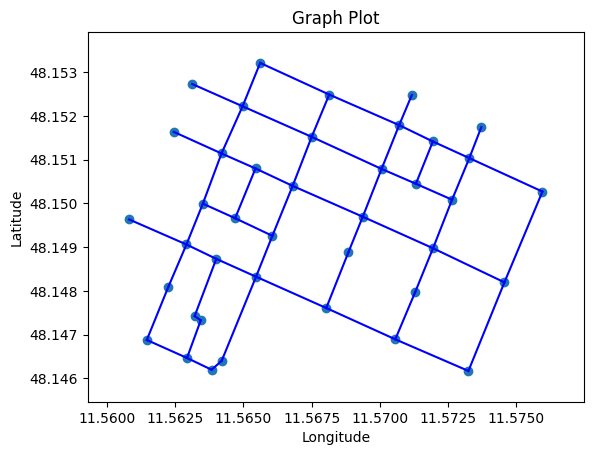

In [9]:
# Initialize a graph object
G = Graph("TUM_SURROUNDINGS")

# Generate an initial routable graph
G.generateFromWays(digital_map)

# Plot the graph
G.plot()

## 3 Determine Origin / Destination

Before the actual routing can be conducted, origin and destination have to be defined. In this exercise, origin and desintation can only be nodes of the graph. Modern navigation systems use more elaborate methods, enabling them to start and end at much more destinations than the ones retained in the routable graph.

For this exercise some example routes have been defined that you can experiment with, but feel free to define your own routes!

Starting to route at: Lat. 48.149994, Lon. 11.56351
Finding path to destination at: Lat. 48.151036, Lon. 11.573283


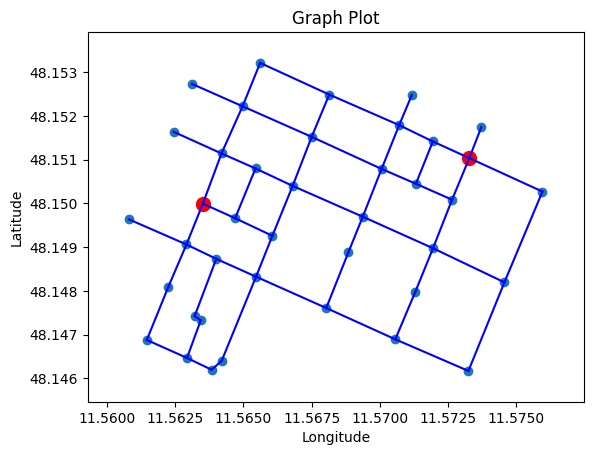

In [10]:
# Choose an example route to use
ROUTE = 1
# Define different example routes
if ROUTE == 1:
    # Example Route 1
    origin = Steinheilstrasse.nodes[0]
    destination = Schellingstrasse.nodes[-2]
if ROUTE == 2:
    # Example Route 2
    origin = BriennerStrasse.nodes[0]
    destination = Tuerkenstrasse.nodes[2]
if ROUTE == 3:
    # Example Route 3 -> Random route
    origin = random.choice(G.nodes) # Choose a random origin
    destination = random.choice([n for n in G.nodes if n!=origin]) #  Random destination that is not the origin

# Some information about Origin and Destination
print("Starting to route at: Lat. {}, Lon. {}".format(origin.lat, origin.lon))
print("Finding path to destination at: Lat. {}, Lon. {}".format(destination.lat, destination.lon))
# Plot the graph and mark origin and destination of the route to be found
G.plot()
plt.scatter([origin.lon, destination.lon], [origin.lat, destination.lat], s= 100, color="r")
plt.show()

## 4 Find Path

The final section of this exercise deals with the implementation of a routing engine and its core element, the routing algorithm. After these have been discussed, a actual routing task is solved.

### 4.1 The Routing Engine

For this practical session, a rudimentary routing engine is to be deployed. The routing engine is implemented as an abstract super class (therefore inheriting from the abc.ABC MetaClass), with the objective of specifying detailled implementations of different routing engines later on. No matter which routing algorithm is used, a routing engine shall always define a "pathCost" method and a "route" method, which is the main method used for routing. If you do not fully grasph the idea of this abstract super class, do not worry and continue with section 4.2 right away, as this super class construct mainly exists to structure this jupyter notebook more efficiently. 

In [11]:
class RoutingEngine(abc.ABC):
    
    # A routing engine usually uses a cost function
    @abc.abstractmethod
    def pathCosts(self, graph, path):
        pass
    
    # A routing engine performs a routing
    @abc.abstractmethod
    def route(self, graph, origin, destination):
        pass           

### 4.2 Dijkstra Implementation

After all the preparation, finally, a routing algorithm has to be implemented. For this exercise, the Dijkstra routing algorithm shall be used. 

The routing algorithm will be implemented by creating a new class "dijkstraRoutingEngine" which inherits from the previously introduced "RoutingEngine" super class. 

"dijkstraRoutingEngine" implements the abstract methods already announced by the "RoutingEngine" super class. Hence, a cost function suitable for the Dijkstra algorithm is defined and the Dijkstra routing algorithm is coded following the verbal explanations from the corresponding lecture slide:

In [12]:
class dijkstraRoutingEngine(RoutingEngine): 
    
    def pathCosts(self, graph, path):

        costs = 0
        
        # If the path is at least two nodes long
        if(len(path)>1):
            # For each pair of nodes on the path
            for i in range(0, len(path)-1):
                # Get the corresponding edge
                graph_edge = graph.getEdgeByNodes(path[i], path[i+1])
                # Add the edge's weight to the costs
                costs = costs + graph_edge.weight
        
        return costs
        
    def route(self, graph, origin, destination):

        # Check if origin and destination exist in the graph 
        if(not(origin in graph.nodes and destination in graph.nodes)):
            raise Exception("Origin and or destination are not part of the Graph")
        
        # From a one-element queue consisting of a zero-length path that contains only the root node
        queue = [[origin]]

        # Until the first path in the queue terminates at the goal node ...
        while queue[0][-1]!=destination:

            # ... or the queue is empty
            if(len(queue)==0):
                # Announce failure
                raise Exception("Could not find a path between origin and destination. Check your graph!")

            # Remove the first path from the queue
            current_path = queue.pop(0)

            # Create new paths by extending the first path to all the neighbors of the terminal node
            new_paths = []
            terminal_node = current_path[-1]

            for neighbor in graph.getNeighbors(terminal_node):
                if neighbor not in current_path: # Reject all paths with loops
                    new_paths.append(current_path+[neighbor])


            # If two or more paths reach a common node, delete all those paths except the one that reaches the
            # common node with the minimum cost
            remove_queue_paths = []
            remove_new_paths = []

            for path in new_paths:
                terminal_node_new_path = path[-1]
    
                for known_path in queue:
                    # If the new terminal node is already existing in any of the paths ...
                    if terminal_node_new_path in known_path:

                        ind = known_path.index(terminal_node_new_path)

                        if ind < len(known_path)-1:
                            known_sub_path = known_path[0:ind+1]
                        else:
                            known_sub_path = known_path

                        known_costs = self.pathCosts(graph, known_sub_path)
                        new_costs = self.pathCosts(graph, path)

                        
                        # ... compare the costs of the new found path to this node with the previously known path to this node
                        # And Remove the more expensive path
                        if known_costs<=new_costs:
                            remove_new_paths.append(path)
                            break
                        else:
                            remove_queue_paths.append(known_path)

                    else:
                        continue

            
            for path in remove_queue_paths:
                queue.remove(path)

            for path in remove_new_paths:
                new_paths.remove(path)

            # Add the new paths, if any, to the queue
            if new_paths:
                for new_path in new_paths:
                    queue.append(new_path)
                    
            # Sort all paths by their accumulated costs
            all_costs = [self.pathCosts(graph, path) for path in queue]

            queue = [path for _,path in sorted(zip(all_costs,queue), key=lambda pair: pair[0])]
            
        return queue[0]           

### 4.3 Other Routing Algorithms

Before the Dijkstra routing algorithm is put to the test, the following template helps you to implement the other routing algorithms from the lecture. You can proceed by implementing any number of the prepared routing algorithms or maybe develope your own! Make sure to use all the available functionalities from the graph class and stick to the wordly explanations on the lecture slides if you can not implement everything yourself.

Have fun and good luck with this little exercise!

In [16]:
# These are exercises left for you to try! They will help you to understand more about the topic.
# Tip: Use the lecture slides to implement the different routing algorithms. Feel free to adapt structures from
# the dijkstra implementation

class breadthFirstRoutingEngine(RoutingEngine):
    
    # Breadth first does not use any cost function. We still have to implement the abstract method from RoutingEngine
    def pathCosts(self, graph, path):
        # You dont have to change anything here
        return 0
    
    def route(self, graph, origin, destination):
        
        # Check if origin and destination exist in the graph 
        if(not(origin in graph.nodes and destination in graph.nodes)):
            raise Exception("Origin and or destination are not part of the Graph")

        # From a one-element queue consisting of a zero-length path that contains only the root node
        queue = [[origin]]

        # Until the first path in the queue terminates at the goal node ...
        while queue[0][-1]!=destination:
                
                # ... or the queue is empty
                if(len(queue)==0):
                    # Announce failure
                    raise Exception("Could not find a path between origin and destination. Check your graph!")
    
                # Remove the first path from the queue
                current_path = queue.pop(0)
    
                # Create new paths by extending the first path to all the neighbors of the terminal node
                new_paths = []
                terminal_node = current_path[-1]
    
                for neighbor in graph.getNeighbors(terminal_node):
                    if neighbor not in current_path:
                        new_paths.append(current_path+[neighbor])

                # Add the new paths, if any, to the queue
                if new_paths:
                    for new_path in new_paths:
                        queue.append(new_path)

        return queue[0]
       

class depthFirstRoutingEngine(RoutingEngine):
    
    # Depth First does not use any cost function. We still have to implement the abstract method from RoutingEngine
    def pathCosts(self, graph, path):
        # You dont have to change anything here
        return 0

    # define route for depth first
        
    def route(self, graph, origin, destination):
        
        # Check if origin and destination exist in the graph 
        if(not(origin in graph.nodes and destination in graph.nodes)):
            raise Exception("Origin and or destination are not part of the Graph")

        # From a one-element queue consisting of a zero-length path that contains only the root node
        queue = [[origin]]

        # Until the first path in the queue terminates at the goal node ...
        while queue[0][-1]!=destination:
                
                # ... or the queue is empty
                if(len(queue)==0):
                    # Announce failure
                    raise Exception("Could not find a path between origin and destination. Check your graph!")
    
                # Remove the first path from the queue
                current_path = queue.pop(0)
    
                # Create new paths by extending the first path to all the neighbors of the terminal node
                new_paths = []
                terminal_node = current_path[-1]
    
                for neighbor in graph.getNeighbors(terminal_node):
                    if neighbor not in current_path:
                        new_paths.append(current_path+[neighbor])

                # Add the new paths, if any, to the queue
                if new_paths:
                    for new_path in new_paths:
                        queue.insert(0, new_path)

        return queue[0]
    
class bestFirstRoutingEngine(RoutingEngine):
    
    def pathCosts(self, graph, path):
            
        costs = 0
        
        # If the path is at least two nodes long
        if(len(path)>1):
            # Using the Shortest Step Heuristic (shortest step to new terminal node is best)
            graph_edge = graph.getEdgeByNodes(path[-1], path[-2])
            costs = graph_edge.weight
            
        return costs
        
    def route(self, graph, origin, destination):
        
        # Check if origin and destination exist in the graph 
        if(not(origin in graph.nodes and destination in graph.nodes)):
            raise Exception("Origin and or destination are not part of the Graph")

        # From a one-element queue consisting of a zero-length path that contains only the root node
        queue = [[origin]]

        # Until the first path in the queue terminates at the goal node ... for best first
        while queue[0][-1]!=destination:
                    
                    # ... or the queue is empty
                    if(len(queue)==0):
                        # Announce failure
                        raise Exception("Could not find a path between origin and destination. Check your graph!")
        
                    # Remove the first path from the queue
                    current_path = queue.pop(0)
        
                    # Create new paths by extending the first path to all the neighbors of the terminal node
                    new_paths = []
                    terminal_node = current_path[-1]
        
                    for neighbor in graph.getNeighbors(terminal_node):
                        if neighbor not in current_path:
                            new_paths.append(current_path+[neighbor])
    
                    # Add the new paths, if any, to the queue
                    if new_paths:
                        for new_path in new_paths:
                            queue.append(new_path)
    
                    # Sort all paths by their accumulated costs
                    all_costs = [self.pathCosts(graph, path) for path in queue]

                    queue = [path for _,path in sorted(zip(all_costs,queue), key=lambda pair: pair[0])]

        return queue[0]






### 4.4 Let's Route

Finally, the moment has come to test our program. If you have bothered to implement routing algorithms by yourself, you can also test your routing algorithms by changing the state of the "ROUTING_ENGINE" option. Remember, that in one of the earlier code snippets, origin and destination of your route have been defined. Change these by scrolling up. Also, feel free to cross check the results with google maps or any osm routing engine.

If there are any differences in the recommended paths: Can you tell why these differences occur? Does the given distance still match the google/osm routing result? <- These are rhetorical questions, no need to write me an E-Mail as long as there are no systematic mistakes in this exercise.

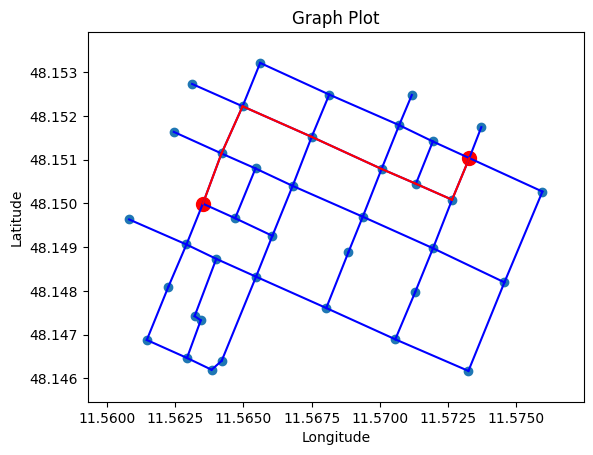

Total path length: 1.003692 km
Routing took 0.689306 s


In [21]:
# Choose a rounting engine! Options are: "dijkstra", "aStar", "breadthFirst", "depthFirst", "bestFirst"
ROUTING_ENGINE = "dijkstra"

# Initialize our routing engine
if ROUTING_ENGINE == "dijkstra":
    re = dijkstraRoutingEngine()
    
elif ROUTING_ENGINE == "depthFirst":
    re = bestFirstRoutingEngine()
    
elif ROUTING_ENGINE == "breadthFirst":
    re = breadthFirstRoutingEngine()
    
elif ROUTING_ENGINE == "depthFirst":
    re = depthFirstRoutingEngine()
    
else:
    raise Exception("Please choose a valid routing engine")

# Used to measure time needed for routing
start = time.time()

# Perform the routing!
path = re.route(G, origin, destination)

# Visualize Results
G.plot()
G.plotPath(path)
plt.scatter([origin.lon, destination.lon], [origin.lat, destination.lat], s = 100, color="r")
plt.show()

# Print route summary
print("Total path length: {:4f} km".format(G.calculatePathLength(path)))
print("Routing took {:4f} s".format(time.time()-start))


## Random Walk and GraphSage Embedding

Update torch and install pytorch-geometric, if not already done.

In [ ]:
# uncomment these lines if you don't have the pytorch geometric library installed 

#!conda install pytorch==1.12.1
#!conda install pyg -c pyg 
#!pip install node2vec

### Generate the an example graph

We generate a small graph, using the networkx python package. First the nodes are defined and get a feature, called "cluster". Afterwards the edges are defined, be aware, self edges( e.g. (1, 1)) need to be explictly defined to. This is skipped in this example.
Afterwards some key characteristics of the graph are printed: the number of nodes, number of edges and the average degree of a node, meaning the average number of edges connected to a node.

In [23]:
# The TSNE function is used to visualize high dimensional data
from sklearn.manifold import TSNE

# These two packages are for graph-data loading and preparation
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

# Pytorch and pytorch geometric for graph convolutional networks
from torch_geometric.nn import GCNConv
import torch
import torch.nn.functional as F

ModuleNotFoundError: No module named 'torch_sparse'

In [ ]:
#Initialize the graph
G = nx.Graph(name='G')

#Create nodes
#In this example, the graph will consist of 6 nodes.
#Each node is assigned node feature which corresponds to the node name
for i in range(1, 9):
    if(i<=3):
        G.add_node(i, cluster=1)
    elif(i>=7):
        G.add_node(i, cluster=3)
    else:
        G.add_node(i, cluster=2)

#Define the edges and the edges to the graph
edges = [(1,2),(2,3),(3,4),(4,5),(5,6),(3,7),(4,7),(7,8)]
G.add_edges_from(edges)


#See graph info
print('Graph Info:\n', nx.info(G))

#Inspect the node features
print('\nGraph Nodes: ', G.nodes.data())

#Plot the graph
labels = nx.get_node_attributes(G, 'cluster') 
nx.draw(G, with_labels=True, labels=labels, font_weight='bold')
plt.show()

### Generate a random graph
To show the possibilities of node embedding a random graph is used. This graph is created by the networkx library. The graph is loosely connected with a social graph, where there are l-differents cliques with each k people. Every clique has one node per other clique, that is connected and this the only connection between these cliques.

In [ ]:
#Initialize the graph
l = 3  # number of cliques
k = 10  # clique size
G = nx.connected_caveman_graph(l, k)

#See graph info
print('Graph Info:\n', nx.info(G))

#Inspect the node features
#print('\nGraph Nodes: ', G.nodes.data())

#Plot the graph
nx.draw(G, font_weight='bold')
plt.show()


### The Node2Vec Algorithm
The node2vec package includes RandomWalk and GraphSage based algorithms. The name node2vec refers to the source of these techniques, Natural Language Processing. The GrpahSage algorithm wa development n the field of NLP as part of the word2vec- algorithm family. Therefore the general node embedding was named node2vec.
The first Step is to create a sequence of random, fixed length walks and tell the model the number of embedding dimensions

In [ ]:
node2vec = Node2Vec(G, dimensions=2, walk_length=5, num_walks=300, workers=1)

The sequene of random walks is stored within the walks attribute of the model and can be manipulated. Afterwards the model needs to be trained. 

In [ ]:
print(node2vec.walks[:3])
model = node2vec.fit()

In [ ]:
# List of the first embedding dimension
embeddingsX = []
# List of the second embedding dimension
embeddingsY = []
# The model identifies the nodes by strings, in this case their id.
for i in range(0, k*l):
    # The embeddings are stored in the wv-attribtute. The naming again is caused by the origin in NLP (wv=wordvector)
    embeddingsX.append(model.wv[str(i)][0])
    embeddingsY.append(model.wv[str(i)][1])

figure = plt.figure(figsize=(11, 9))
ax = figure.add_subplot(111)
ax.scatter(embeddingsX, embeddingsY, label=[range(1, 9)],  marker='o', c='b', s=30)



In [ ]:
from sklearn.cluster import KMeans

X = []
for i in range(0, k*l):
    X.append([model.wv[str(i)][0], model.wv[str(i)][1]])

kmeans = KMeans(n_clusters=3).fit_predict(X)

figure = plt.figure(figsize=(11, 9))
ax = figure.add_subplot(111)
#Getting unique labels
u_labels = np.unique(kmeans)
 
#plotting the results:
for i in u_labels:
    ind = [j for j, cluster in enumerate(kmeans) if cluster==i]
    plt.scatter([embeddingsX[cluster] for cluster in ind] , [embeddingsY[cluster] for cluster in ind] , label = i)

In [ ]:
# Helper function for visualization.
%matplotlib inline

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

# Graph Convolutional Network with Pytorch

### Data Loading    
To build a meaningful GCN a sophisticated graph is needed. In this example we use the Cora dataset from `"Revisiting Semi-Supervised Learning with Graph Embeddings"
    <https://arxiv.org/abs/1603.08861>`.
Nodes represent  documents and edges represent citation links. Training and validation splits are also pre-given. 

In [ ]:
dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('===========================================================================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

From the CORA dataset documentation: (https://relational.fit.cvut.cz/dataset/CORA)
The Cora dataset consists of 2708 scientific publications classified into one of seven classes. The citation network consists of 5429 links. Each publication in the dataset is described by a 0/1-valued word vector indicating the absence/presence of the corresponding word from the dictionary. The dictionary consists of 1433 unique words.

### The GCN  Model
Next the Neural Network needs to be defined. For GCNs in pytorch, this happens the same way as with non graph based neural  networks. Just use the GCNConv class for the Layers.

In [ ]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GCN(hidden_channels=16)
model.eval()
print(model)

In pytorch and graph neural networks, the convention is, that the node feature x represents the feature vector and the feature y represents the corresponding output vector, e.g. the class for a classification task.

In [ ]:
print(data.y)

In [ ]:
out = model(data.x, data.edge_index)
visualize(out, color=data.y)

### Training
For the training the usd optimizer and the loss function need to be defined.

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x, data.edge_index)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test():
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc


for epoch in range(1, 101):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

In [ ]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Now we can visualize the y-feature again and see the model output. The visualize function is a used helper function to visualize high-dimnesional output.

In [ ]:
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)